In [2]:
#Import Packages
import sys
import pickle
import os
import pytz
import datetime
import string
import re
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from windrose import WindroseAxes
import xarray as xr
from pylr2 import regress2
sys.path.append('..')
import funcs.ac_funcs as ac
pd.options.mode.chained_assignment = None
#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def trim_ds(ds,extent_dict):
    sub_ds =  ds.sel(lat=slice(extent_dict['lat_low'],
                               extent_dict['lat_high']),
                     lon=slice(extent_dict['lon_low'],
                               extent_dict['lon_high']))
    return sub_ds

def get_sum_value(ds):
    return float(ds.sum().to_array().values)

# Inventories

In [54]:
dataset_extent = {'lon_low':-112.1,
                  'lon_high':-111.7,
                  'lat_low':40.4,
                  'lat_high':41.0} 


## EDGAR

In [5]:
def load_edgar_nc(edgar_path,spec,emi_or_flx,year):
    nc_folder_name = f'v8.0_FT2022_GHG_{spec}_{year}_TOTALS_emi_nc'
    nc_file_name = '_'.join(nc_folder_name.split('_')[:-1]) + '.nc'
    nc_fullpath = os.path.join(edgar_path,spec,emi_or_flx,nc_folder_name,nc_file_name)
    return xr.open_dataset(nc_fullpath)

def plot_co2_ch4_sbs(edgar_inventories,map_extent,year,totals_dict):
    labsize = 12
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(12,7))

    spec = 'CO2'
    inventory_ds = edgar_inventories[spec]
    ax = fig.add_subplot(121,projection = proj)
    ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
    request = cimgt.GoogleTiles(style='satellite')
    scale = 10.0 # prob have to adjust this
    ax.add_image(request,int(scale))
    map = inventory_ds['emissions'].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
    plt.colorbar(map,fraction=0.03,label = f'{spec} Emissions (Tonnes, {year})')

    spec = 'CH4'
    inventory_ds = edgar_inventories[spec]
    ax = fig.add_subplot(122,projection = proj)
    ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
    request = cimgt.GoogleTiles(style='satellite')
    scale = 10.0 # prob have to adjust this
    ax.add_image(request,int(scale))
    map = inventory_ds['emissions'].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
    plt.colorbar(map,fraction=0.03,label = f'{spec} Emissions (Tonnes, {year})')

    co2_total = int(totals_dict[year]['CO2_sum'])
    t0 = fig.text(0.2,0.78,f'CO2_sum={co2_total} ton',fontsize = labsize)
    t0.set_bbox(dict(facecolor = 'white'))

    ch4_total = int(totals_dict[year]['CH4_sum'])
    ch4_from_ratio = int(totals_dict[year]['CH4_from_ratio'])
    text = f'CH4_sum={ch4_total} ton\nCH4_ratio={ch4_from_ratio} ton'
    t1 = fig.text(0.65,0.73,text,fontsize = labsize)
    t1.set_bbox(dict(facecolor = 'white'))
    plt.suptitle(year,y=0.85)
    plt.show()

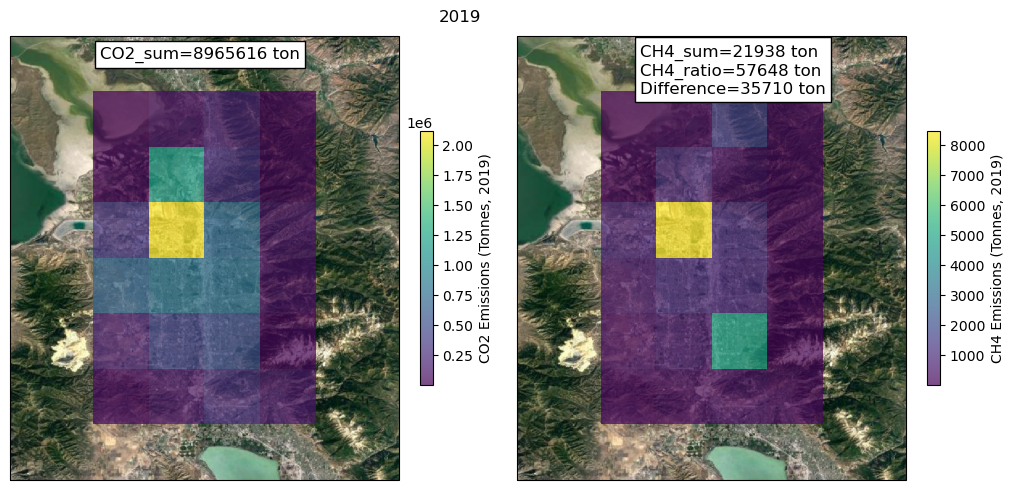

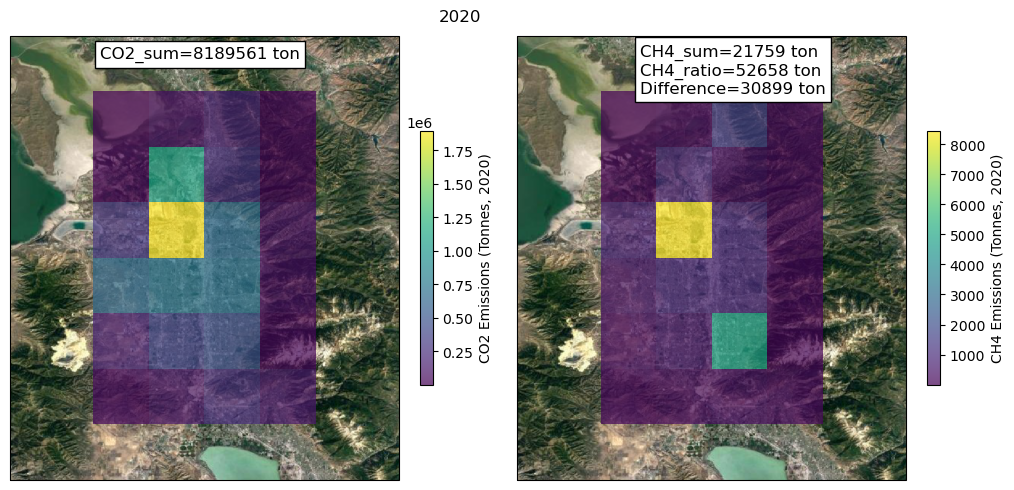

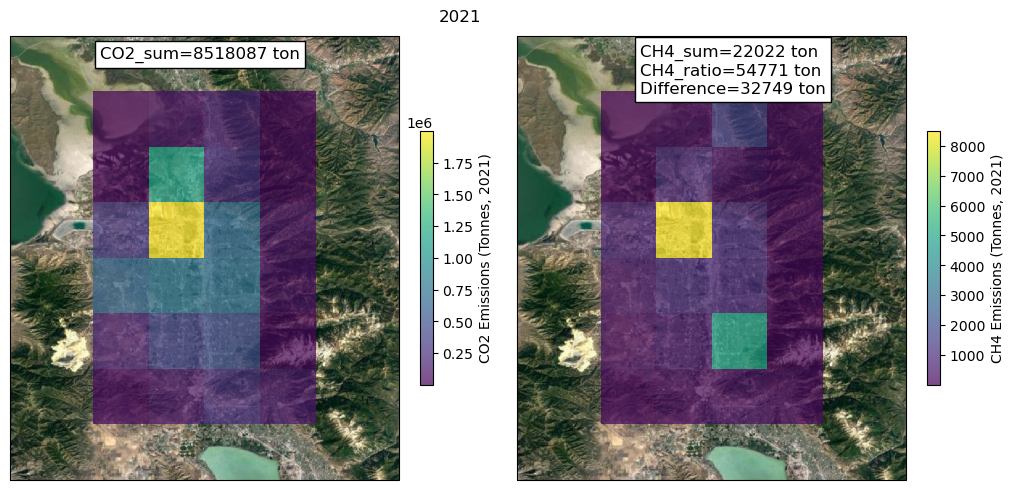

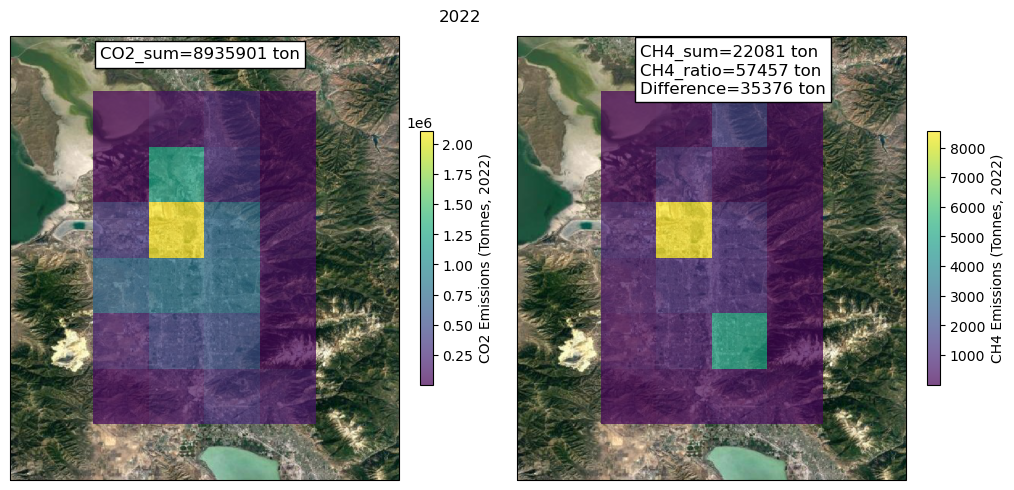

In [6]:
#Load Edgar inventories
edgar_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/EDGAR/'

ch4_co2_ratio = 6.43E-3

species = ['CO2','CH4']
years = [2019,2020,2021,2022]
emi_or_flx = 'emi'


map_extent={'lon_low':-112.25,
            'lon_high':-111.55,
            'lat_low':40.3,
            'lat_high':41.1} 

totals_dict ={}
for year in years:
    edgar_subsets = {}
    totals_dict[year] = {}
    for spec in species:
        full_inventory = load_edgar_nc(edgar_path,spec,emi_or_flx,year)
        sub_inventory = trim_ds(full_inventory,dataset_extent)
        edgar_subsets[spec] = sub_inventory
        totals_dict[year][f'{spec}_sum'] = get_sum_value(sub_inventory)
    totals_dict[year]['CH4_from_ratio'] = ch4_co2_ratio*totals_dict[year]['CO2_sum']
    
    
    
#plot_co2_ch4_sbs(edgar_subsets,map_extent,year,totals_dict)

## Maasakkers EPA

In [7]:
epa_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/Maasakkers'
fname = 'Express_Extension_Gridded_GHGI_Methane_v2_2019.nc'
epa_full = xr.open_dataset(os.path.join(epa_path,fname))
epa_subset = trim_ds(epa_full,dataset_extent).sum(dim="time")
epa_subset_df = epa_subset.to_dataframe()

new_df = pd.DataFrame().reindex_like(epa_subset_df)
new_df = new_df.drop('grid_cell_area',axis = 1)
for col in new_df.columns:
    new_df[col] = epa_subset_df.apply(lambda row: row[col] * row['grid_cell_area'],axis = 1)
(new_df.sum().sum())*(1/6.022E23)*16.04E-12*86400*365*1000000

24045.090964220028

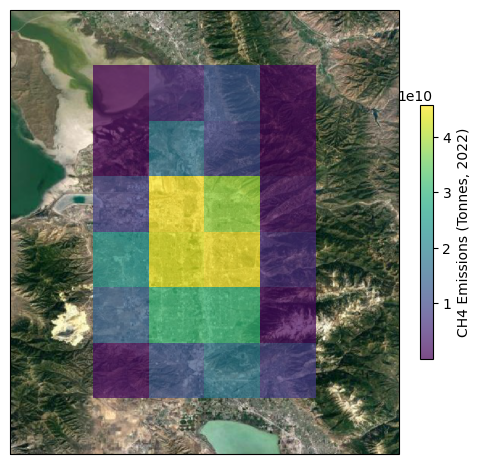

In [8]:
labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12,7))

spec = 'CH4'
inventory_ds = epa_subset
ax = fig.add_subplot(121,projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))
map = inventory_ds['emi_ch4_1A_Combustion_Mobile'].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
plt.colorbar(map,fraction=0.03,label = f'{spec} Emissions (Tonnes, {year})')


plt.show()

## NOAA CSL

In [23]:
# Load CO2 csl for weekday in jan
co2_wkd_csl = xr.open_dataset('/uufs/chpc.utah.edu/common/home/lin-group10/HKH/CLS_NOAA_Emissions/Emission_Eval/NCDF_Grid_SLV/WKD_nc/CO2_WKD_2019_01_NOAA_CSL_SLV_lon.lat.nc')
co2_wkd_csl = trim_ds(co2_wkd_csl,dataset_extent)
co2_csl_timesum = co2_wkd_csl.sum(dim='hour_UTC')
summed_csl_da = xr.full_like(co2_csl_timesum['CO2_EGU_point'],0)
for data_var in list(co2_csl_timesum.data_vars):
    summed_csl_da = summed_csl_da + co2_csl_timesum[data_var]

In [42]:
co2_csl_timemean = co2_wkd_csl.mean(dim='hour_UTC')
summed_csl_da = xr.full_like(co2_csl_timemean['CO2_EGU_point'],0)
for data_var in list(co2_csl_timemean.data_vars):
    summed_csl_da = summed_csl_da + co2_csl_timemean[data_var]

In [55]:
x = 0
for data_var in list(co2_csl_timemean.data_vars):
    x+= float(co2_csl_timemean[data_var].mean())
x * 86400 / 1E6 * 365 * 16 /1E6 *2259838224


4390243.264159589

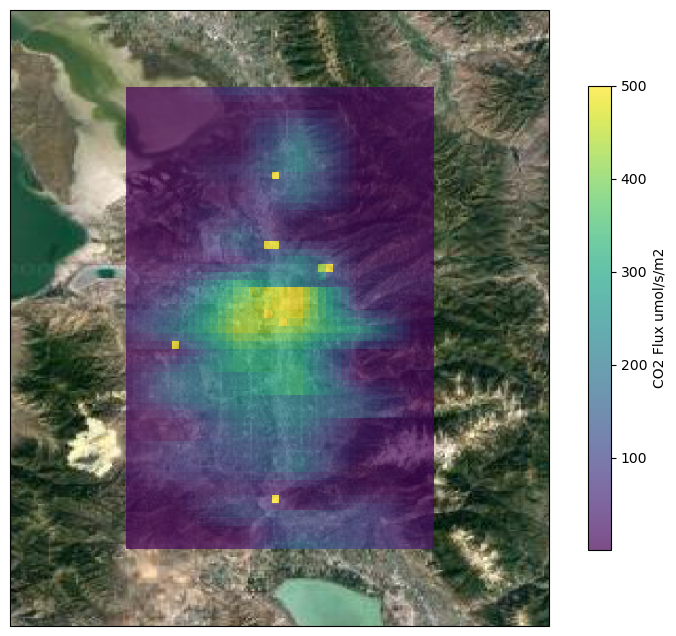

In [24]:
#Plot it
labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 9.0 # prob have to adjust this
ax.add_image(request,int(scale))

map = summed_csl_da.plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False,vmax = 500)
plt.colorbar(map,fraction=0.03,label ='CO2 Flux umol/s/m2')
plt.show()